## --- Cell 1: Libraries ---

In [1]:
# Core Python libraries
!pip install numpy pandas scikit-learn xgboost imbalanced-learn matplotlib

# Homomorphic encryption libraries
!pip install pyfhel

print("Libraries installed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Created wheel for pyfhel: filename=pyfhel-3.5.0-cp312-cp312-linux_x86_64.whl size=10522634 sha256=b598d7be968f79ae563b22a5689302b1f0c7365d48e3f81cccdb0e48e915bd5f
  Stored in directory: /root/.cache/pip/wheels/e2/63/dc/92a25670f3df13fb7b9357733325530e362dd76752d673785f
Successfully built pyfhel
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

Libraries installed.


## --- Cell 2: Imports ---

In [1]:
import time
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
from Pyfhel import Pyfhel

## --- Cell 3: Data Preprocessing ---

In [2]:
print("Loading and preprocessing data...")
try:
    # 1. Load the original dataset
    !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data

    cols = ['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount',
            'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties',
            'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing',
            'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class']

    df = pd.read_csv('german.data', sep=' ', header=None, names=cols)

    # 2. Encode target variable: 1 (bad) -> 1, 2 (good) -> 0
    df['target'] = (df['class'] == 1).astype(int)
    df = df.drop(columns=['class'])

    # 3. Identify categorical and numerical features
    categorical_features = df.select_dtypes(include=['object']).columns
    numerical_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['target']).columns

    # 4. Apply one-hot encoding to categorical columns
    df_processed = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    # 5. Convert boolean columns to integer
    for col in df_processed.columns:
        if df_processed[col].dtype == 'bool':
            df_processed[col] = df_processed[col].astype(int)

    print(f"Data shape after preprocessing: {df_processed.shape}")

    # 7. Split into features (X) and target (y)
    X = df_processed.drop(columns=['target'])
    y = df_processed['target']

    # 8. Split into training and testing (80/20)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Original train shape: {X_train_orig.shape}, Original test shape: {X_test_orig.shape}")
    print("✅ Data preprocessing and splitting complete.")

except Exception as e:
    print(f"⚠️ Error loading/preprocessing data: {e}")
    print("Please ensure 'german.data' is available or the download link is valid.")

Loading and preprocessing data...
Data shape after preprocessing: (1000, 49)
Original train shape: (800, 48), Original test shape: (200, 48)
✅ Data preprocessing and splitting complete.


## --- Cell 4: SMOTE Balancing ---

In [3]:
print("\nApplying SMOTE to balance the training data...")
smote = SMOTE(random_state=42)
X_train_full_bal, y_train_bal = smote.fit_resample(X_train_orig, y_train_orig)
y_test_bal = y_test_orig.copy() # Test data is not resampled

print(f"New balanced training data shape: {X_train_full_bal.shape}")
print(f"New balanced training labels: {y_train_bal.value_counts().to_dict()}")


Applying SMOTE to balance the training data...
New balanced training data shape: (1120, 48)
New balanced training labels: {1: 560, 0: 560}


## --- Cell 5: Column Sanitization ---

In [4]:
print("\nSanitizing column names for XGBoost...")
def sanitize_colnames(df):
    new_cols = [re.sub(r"[\\[\\]<]", "_", col) for col in df.columns]
    df.columns = new_cols
    return df

# Sanitize all data partitions
X_train_full_bal = sanitize_colnames(X_train_full_bal)
X_test_orig = sanitize_colnames(X_test_orig.copy()) # Use a copy to avoid SettingWithCopyWarning
X_test_full_bal = X_test_orig[X_train_full_bal.columns] # Ensure test columns match train

# Store original column list for splitting
original_cols = X_train_full_bal.columns.tolist()


Sanitizing column names for XGBoost...


## --- Cell 6: Data Partitioning (2-Party and 4-Party) ---

In [5]:
print("\nCreating data partitions...")

# 2-PARTY SPLIT (Simple, non-randomized)
n_2p = len(original_cols)
split_idx_2p = n_2p // 2
cols_A_2p = original_cols[:split_idx_2p]
cols_B_2p = original_cols[split_idx_2p:]

# 2-Party Train (Balanced)
XA_train_2p = X_train_full_bal[cols_A_2p].reset_index(drop=True)
XB_train_2p = X_train_full_bal[cols_B_2p].reset_index(drop=True)

# 2-Party Test
XA_test_2p = X_test_full_bal[cols_A_2p].reset_index(drop=True)
XB_test_2p = X_test_full_bal[cols_B_2p].reset_index(drop=True)

print(f"2-Party Split: Party A ({len(cols_A_2p)} features), Party B ({len(cols_B_2p)} features)")

# 4-PARTY SPLIT (Randomized)
random.seed(42)
shuffled_cols_4p = random.sample(original_cols, len(original_cols))
split_indices_4p = np.array_split(range(len(shuffled_cols_4p)), 4)
cols_4p = [[shuffled_cols_4p[i] for i in idx] for idx in split_indices_4p]

# 4-Party Train (Balanced)
X_train_parties_4p = [X_train_full_bal[c].reset_index(drop=True) for c in cols_4p]

# 4-Party Test
X_test_parties_4p = [X_test_full_bal[c].reset_index(drop=True) for c in cols_4p]

print(f"4-Party Split (Randomized): Parties 0-3 with {[len(c) for c in cols_4p]} features")


Creating data partitions...
2-Party Split: Party A (24 features), Party B (24 features)
4-Party Split (Randomized): Parties 0-3 with [12, 12, 12, 12] features


## --- Cell 7: Scalers (Apply locally to each partition) ---

In [6]:
print("\nApplying local scaling to all partitions...")

# 2-Party Scalers
scaler_A_2p = StandardScaler().fit(XA_train_2p)
scaler_B_2p = StandardScaler().fit(XB_train_2p)

XA_train_2p_s = pd.DataFrame(scaler_A_2p.transform(XA_train_2p), columns=cols_A_2p)
XB_train_2p_s = pd.DataFrame(scaler_B_2p.transform(XB_train_2p), columns=cols_B_2p)

XA_test_2p_s = pd.DataFrame(scaler_A_2p.transform(XA_test_2p), columns=cols_A_2p)
XB_test_2p_s = pd.DataFrame(scaler_B_2p.transform(XB_test_2p), columns=cols_B_2p)

X_train_2p_list_s = [XA_train_2p_s, XB_train_2p_s]
X_test_2p_list_s = [XA_test_2p_s, XB_test_2p_s]

# 4-Party Scalers
scalers_4p = [StandardScaler().fit(Xp) for Xp in X_train_parties_4p]

X_train_4p_list_s = [pd.DataFrame(scalers_4p[i].transform(X_train_parties_4p[i]), columns=cols_4p[i]) for i in range(4)]
X_test_4p_list_s = [pd.DataFrame(scalers_4p[i].transform(X_test_parties_4p[i]), columns=cols_4p[i]) for i in range(4)]

print("✅ All data splits created and scaled.")


Applying local scaling to all partitions...
✅ All data splits created and scaled.


## --- Cell 8: SecureBoostClassifier (N-Party, max_depth > 1) ---

In [7]:
class SecureBoostClassifier:
    """
    A SecureBoost classifier supporting N passive parties, max_depth > 1,
    and using Pyfhel (CKKS) for HE.
    """
    def __init__(self, rounds=50, bins=16, lr=0.1, lmbda=1.0, gamma=0.0, max_depth=3):
        self.rounds = rounds
        self.bins = bins
        self.lr = lr
        self.lmbda = lmbda
        self.gamma = gamma
        self.max_depth = max_depth
        self.trees_ = []
        self.initial_pred_ = 0.0
        self.history_ = {'train_auc': [], 'round_times': []}

        print("Initializing Homomorphic Encryption context...")
        self.HE = Pyfhel()
        self.HE.contextGen(scheme='ckks', n=8192, scale=2**40, qi_sizes=[60, 40, 40, 60])
        self.HE.keyGen()
        self.HE.relinKeyGen()
        print("HE Context Ready. 🔒")

    def _encrypt_vector(self, val):
        return self.HE.encrypt(np.array([val]))

    def _decrypt_scalar(self, ctxt):
        return self.HE.decrypt(ctxt)[0]

    def _compute_grad_hess(self, y_true, y_pred_log_odds):
        prob = 1 / (1 + np.exp(-y_pred_log_odds))
        return prob - y_true, prob * (1 - prob)

    def _compute_gain(self, GL, HL, GR, HR):
        score_L = (GL**2) / (HL + self.lmbda)
        score_R = (GR**2) / (HR + self.lmbda)
        score_parent = ((GL + GR)**2) / (HL + HR + self.lmbda)
        return score_L + score_R - score_parent - self.gamma

    def _compute_leaf_weight(self, G, H):
        return -G / (H + self.lmbda)

    def _get_encrypted_histograms(self, X_party, enc_g, enc_h):
        n_features = X_party.shape[1]
        enc_g_sums = [[self._encrypt_vector(0.0) for _ in range(self.bins)] for _ in range(n_features)]
        enc_h_sums = [[self._encrypt_vector(0.0) for _ in range(self.bins)] for _ in range(n_features)]
        bin_edges = []

        for j in range(n_features):
            col = X_party.iloc[:, j]
            edges = np.unique(np.quantile(col, np.linspace(0, 1, self.bins + 1)))
            if len(edges) < 2: edges = np.array([col.min(), col.max()])
            if len(edges) < 2 or edges[0] == edges[1]: edges = np.array([edges[0] - 0.5, edges[0] + 0.5])
            bin_edges.append(edges)

            num_bins_created = len(edges) - 1
            bin_idxs = np.clip(np.digitize(col, edges) - 1, 0, num_bins_created - 1)

            for i in range(len(col)):
                b = bin_idxs[i]
                if b < self.bins: # Ensure we don't go out of bounds
                    enc_g_sums[j][b] += enc_g[i]
                    enc_h_sums[j][b] += enc_h[i]

        return enc_g_sums, enc_h_sums, bin_edges

    def _find_best_split(self, enc_g_sums, enc_h_sums, bins, party_name):
        best = {"gain": -1e9, "party": party_name}
        for j in range(len(enc_g_sums)):
            if len(bins[j]) < 2: continue

            dec_g = [self._decrypt_scalar(g) for g in enc_g_sums[j]]
            dec_h = [self._decrypt_scalar(h) for h in enc_h_sums[j]]

            G_prefix, H_prefix = np.cumsum(dec_g), np.cumsum(dec_h)
            if len(G_prefix) == 0: continue

            TotalG, TotalH = G_prefix[-1], H_prefix[-1]

            for i in range(len(bins[j]) - 2): # Iterate over possible split points
                if i >= len(G_prefix): break # Edge case for empty bins
                GL, HL = G_prefix[i], H_prefix[i]
                GR, HR = TotalG - GL, TotalH - HL

                if HL < 1e-3 or HR < 1e-3: continue

                gain = self._compute_gain(GL, HL, GR, HR)

                if gain > best['gain']:
                    best = {
                        "gain": gain,
                        "party": party_name,
                        "feature": j,
                        "threshold": bins[j][i + 1],
                        "left_stats": (GL, HL),
                        "right_stats": (GR, HR)
                    }
        return best

    def _build_tree(self, X_parties, g, h, depth):
        if depth == self.max_depth or len(g) < 5: # min_samples_leaf=5
            return {"leaf_weight": self._compute_leaf_weight(np.sum(g), np.sum(h))}

        enc_g = [self._encrypt_vector(val) for val in g]
        enc_h = [self._encrypt_vector(val) for val in h]

        all_best_splits = []
        for i, X_party in enumerate(X_parties):
            enc_g_sums, enc_h_sums, bins = self._get_encrypted_histograms(X_party, enc_g, enc_h)
            all_best_splits.append(self._find_best_split(enc_g_sums, enc_h_sums, bins, party_name=i))

        best = max(all_best_splits, key=lambda x: x['gain'])

        if best['gain'] <= 0:
            return {"leaf_weight": self._compute_leaf_weight(np.sum(g), np.sum(h))}

        party_idx, feat_idx, thresh = best['party'], best['feature'], best['threshold']

        # Get the feature column from the correct party
        mask_left = X_parties[party_idx].iloc[:, feat_idx] <= thresh

        # Partition all party dataframes, not just the one with the split
        X_left = [df[mask_left] for df in X_parties]
        X_right = [df[~mask_left] for df in X_parties]

        return {
            "party": party_idx,
            "feature": feat_idx,
            "threshold": thresh,
            "left": self._build_tree(X_left, g[mask_left], h[mask_left], depth + 1),
            "right": self._build_tree(X_right, g[~mask_left], h[~mask_left], depth + 1)
        }

    def fit(self, X_parties, y):
        y_np = y.values if isinstance(y, pd.Series) else y
        self.initial_pred_ = np.log(np.mean(y_np) / (1 - np.mean(y_np)))

        # This array holds the predictions *for the training set* and is updated each round
        self.preds_train_ = np.full(len(y_np), self.initial_pred_)

        # Create copies of training data for recursive splitting
        X_train_dfs = [df.copy() for df in X_parties]

        print(f"Training starting. Rounds={self.rounds}, Max Depth={self.max_depth}, Parties={len(X_parties)}")
        for r in range(self.rounds):
            t_start = time.time()
            print(f"Round {r+1}/{self.rounds} building tree...", end="\r")

            g, h = self._compute_grad_hess(y_np, self.preds_train_)

            # Pass the *full* party dataframes each time for splitting
            tree = self._build_tree(X_train_dfs, g, h, depth=0)
            self.trees_.append(tree)

            # Update preds_train_ for the *next* round
            # We pass the full data and an index list to track splits
            self._update_preds_recursive(tree, X_train_dfs, np.arange(len(y_np)))

            auc = roc_auc_score(y_np, 1 / (1 + np.exp(-self.preds_train_)))
            self.history_['train_auc'].append(auc)
            self.history_['round_times'].append(time.time() - t_start)
            print(f"Round {r+1}/{self.rounds} done. Train AUC: {auc:.4f} ({self.history_['round_times'][-1]:.1f}s)")

        return self

    def _update_preds_recursive(self, node, X_parties, idxs):
        """Recursively updates the self.preds_train_ array based on the new tree."""
        if "leaf_weight" in node:
            self.preds_train_[idxs] += self.lr * node["leaf_weight"]
            return

        party_idx = node['party']
        feat_idx = node['feature']

        # Get the feature values for the *current subset of samples* (defined by idxs)
        feat_vals = X_parties[party_idx].iloc[idxs, feat_idx].values

        mask = (feat_vals <= node['threshold'])

        # Get the global indices for left and right children
        idxs_left = idxs[mask]
        idxs_right = idxs[~mask]

        self._update_preds_recursive(node['left'], X_parties, idxs_left)
        self._update_preds_recursive(node['right'], X_parties, idxs_right)

    def _predict_row_recursive(self, node, row_parties):
        """Predicts a single row, represented as a list of party feature arrays."""
        if "leaf_weight" in node:
            return self.lr * node["leaf_weight"]

        val = row_parties[node['party']][node['feature']]

        if val <= node['threshold']:
            return self._predict_row_recursive(node['left'], row_parties)
        else:
            return self._predict_row_recursive(node['right'], row_parties)

    def predict_proba(self, X_parties):
        preds = np.full(len(X_parties[0]), self.initial_pred_)

        # Convert to numpy for faster row access
        X_parties_np = [df.values for df in X_parties]

        for i in range(len(X_parties[0])):
            # Create a list of np.arrays, one for each party's row
            row_parties = [df_np[i] for df_np in X_parties_np]

            for tree in self.trees_:
                preds[i] += self._predict_row_recursive(tree, row_parties)

        probs = 1 / (1 + np.exp(-preds))
        return np.vstack([1-probs, probs]).T

print("✅ SecureBoostClassifier (N-Party, max_depth>1) defined.")

✅ SecureBoostClassifier (N-Party, max_depth>1) defined.


## --- Cell 9: Experiment Run 1 - Centralized XGBoost ---

In [8]:
print("\n" + "="*30)
print("🚀 RUN 1: Centralized XGBoost")
print("="*30)

# Params from File 3 Markdown
params_xgb = {
    'n_estimators': 50,
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42
}
baseline_xgb = xgb.XGBClassifier(**params_xgb)

start_xgb = time.time()
baseline_xgb.fit(X_train_full_bal, y_train_bal)
time_centralized = time.time() - start_xgb

print(f"\n✅ Centralized Training Complete.")
print(f"⏱️ Time Taken: {time_centralized:.4f} seconds")

# Evaluate
y_pred_xgb_proba = baseline_xgb.predict_proba(X_test_full_bal)[:, 1]
auc_xgb = roc_auc_score(y_test_bal, y_pred_xgb_proba)
print(f"🎯 Test AUC: {auc_xgb:.4f}")


🚀 RUN 1: Centralized XGBoost

✅ Centralized Training Complete.
⏱️ Time Taken: 0.3370 seconds
🎯 Test AUC: 0.7694


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:56:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## --- Cell 10: Experiment Run 2 - 2-Party SecureBoost ---

In [9]:
print("\n" + "="*30)
print("🚀 RUN 2: 2-Party SecureBoost (max_depth=2)")
print("="*30)

# Best params from File 3
params_sb = {
    'rounds': 50,
    'bins': 32,
    'lr': 0.1,
    'lmbda': 1.0,
    'gamma': 0.0,
    'max_depth': 2
}
sb_2p = SecureBoostClassifier(**params_sb)

start_2p = time.time()
sb_2p.fit(X_train_2p_list_s, y_train_bal)
time_2p = time.time() - start_2p

print(f"\n✅ 2-Party Training Complete.")
print(f"⏱️ Time Taken: {time_2p / 60:.4f} minutes")

# Evaluate
y_pred_2p_proba = sb_2p.predict_proba(X_test_2p_list_s)[:, 1]
auc_2p = roc_auc_score(y_test_bal, y_pred_2p_proba)
print(f"🎯 Test AUC: {auc_2p:.4f}")


🚀 RUN 2: 2-Party SecureBoost (max_depth=2)
Initializing Homomorphic Encryption context...
HE Context Ready. 🔒
Training starting. Rounds=50, Max Depth=2, Parties=2
Round 1/50 done. Train AUC: 0.6876 (122.5s)
Round 2/50 done. Train AUC: 0.7154 (118.1s)
Round 3/50 done. Train AUC: 0.7692 (117.9s)
Round 4/50 done. Train AUC: 0.8004 (117.0s)
Round 5/50 done. Train AUC: 0.7851 (118.7s)
Round 6/50 done. Train AUC: 0.7914 (129.8s)
Round 7/50 done. Train AUC: 0.8002 (124.9s)
Round 8/50 done. Train AUC: 0.8005 (126.4s)
Round 9/50 done. Train AUC: 0.8024 (118.3s)
Round 10/50 done. Train AUC: 0.8028 (118.7s)
Round 11/50 done. Train AUC: 0.8274 (119.0s)
Round 12/50 done. Train AUC: 0.8284 (117.6s)
Round 13/50 done. Train AUC: 0.8274 (123.1s)
Round 14/50 done. Train AUC: 0.8272 (116.9s)
Round 15/50 done. Train AUC: 0.8286 (115.5s)
Round 16/50 done. Train AUC: 0.8309 (116.7s)
Round 17/50 done. Train AUC: 0.8354 (114.6s)
Round 18/50 done. Train AUC: 0.8386 (117.5s)
Round 19/50 done. Train AUC: 0.8374

## --- Cell 11: Experiment Run 3 - 4-Party SecureBoost ---

In [10]:
print("\n" + "="*30)
print("🚀 RUN 3: 4-Party SecureBoost (max_depth=2)")
print("="*30)

# Use same best params
sb_4p = SecureBoostClassifier(**params_sb)

start_4p = time.time()
sb_4p.fit(X_train_4p_list_s, y_train_bal)
time_4p = time.time() - start_4p

print(f"\n✅ 4-Party Training Complete.")
print(f"⏱️ Time Taken: {time_4p / 60:.4f} minutes")

# Evaluate
y_pred_4p_proba = sb_4p.predict_proba(X_test_4p_list_s)[:, 1]
auc_4p = roc_auc_score(y_test_bal, y_pred_4p_proba)
print(f"🎯 Test AUC: {auc_4p:.4f}")


🚀 RUN 3: 4-Party SecureBoost (max_depth=2)
Initializing Homomorphic Encryption context...
HE Context Ready. 🔒
Training starting. Rounds=50, Max Depth=2, Parties=4
Round 1/50 done. Train AUC: 0.6876 (118.4s)
Round 2/50 done. Train AUC: 0.7154 (115.6s)
Round 3/50 done. Train AUC: 0.7692 (116.3s)
Round 4/50 done. Train AUC: 0.8004 (115.0s)
Round 5/50 done. Train AUC: 0.7851 (116.0s)
Round 6/50 done. Train AUC: 0.7914 (116.0s)
Round 7/50 done. Train AUC: 0.8012 (117.4s)
Round 8/50 done. Train AUC: 0.8019 (117.6s)
Round 9/50 done. Train AUC: 0.8035 (118.3s)
Round 10/50 done. Train AUC: 0.8041 (117.4s)
Round 11/50 done. Train AUC: 0.8280 (117.9s)
Round 12/50 done. Train AUC: 0.8288 (117.5s)
Round 13/50 done. Train AUC: 0.8279 (118.4s)
Round 14/50 done. Train AUC: 0.8277 (116.2s)
Round 15/50 done. Train AUC: 0.8291 (117.7s)
Round 16/50 done. Train AUC: 0.8313 (117.5s)
Round 17/50 done. Train AUC: 0.8359 (117.1s)
Round 18/50 done. Train AUC: 0.8391 (117.6s)
Round 19/50 done. Train AUC: 0.8376

## --- Cell 12: Results Storage & Plotting ---

Combined plot saved (designed for 2-column span in LaTeX)


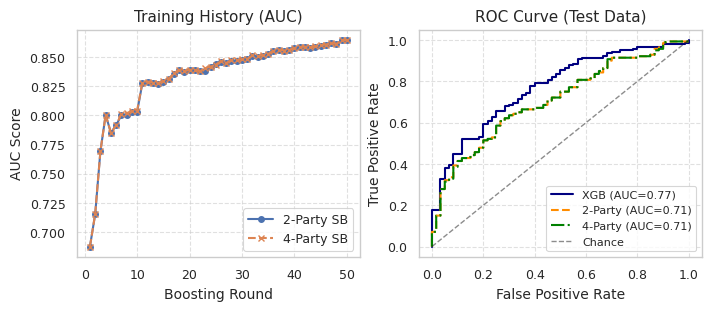

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Set styling for publication
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.1)

# Size for spanning TWO columns in IEEE (~7 inches wide, 3 inches high)
# constrained_layout=True often handles subplots better than tight_layout
fig, axes = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)

# --- Plot 1: Training History (AUC over rounds) ---
ax1 = axes[0]
rounds_2p = range(1, len(sb_2p.history_['train_auc']) + 1)
rounds_4p = range(1, len(sb_4p.history_['train_auc']) + 1)

ax1.plot(rounds_2p, sb_2p.history_['train_auc'], marker='o', markersize=4, linestyle='-', linewidth=1.5, label='2-Party SB')
ax1.plot(rounds_4p, sb_4p.history_['train_auc'], marker='x', markersize=4, linestyle='--', linewidth=1.5, label='4-Party SB')

ax1.set_title('Training History (AUC)', fontsize=11)
ax1.set_xlabel('Boosting Round', fontsize=10)
ax1.set_ylabel('AUC Score', fontsize=10)
ax1.legend(fontsize=9, loc='best')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(labelsize=9)

# --- Plot 2: ROC Curves on Test Data ---
ax2 = axes[1]

# Calculate ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bal, y_pred_xgb_proba)
fpr_2p, tpr_2p, _ = roc_curve(y_test_bal, y_pred_2p_proba)
fpr_4p, tpr_4p, _ = roc_curve(y_test_bal, y_pred_4p_proba)

# Calculate final AUCs
auc_xgb = roc_auc_score(y_test_bal, y_pred_xgb_proba)
auc_2p = roc_auc_score(y_test_bal, y_pred_2p_proba)
auc_4p = roc_auc_score(y_test_bal, y_pred_4p_proba)

# Plot curves (shortened labels for cleaner legend in small space)
ax2.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC={auc_xgb:.2f})', color='navy', lw=1.5)
ax2.plot(fpr_2p, tpr_2p, ls='--', label=f'2-Party (AUC={auc_2p:.2f})', color='darkorange', lw=1.5)
ax2.plot(fpr_4p, tpr_4p, ls='-.', label=f'4-Party (AUC={auc_4p:.2f})', color='green', lw=1.5)
ax2.plot([0, 1], [0, 1], 'k--', label='Chance', lw=1, alpha=0.5)

ax2.set_title('ROC Curve (Test Data)', fontsize=11)
ax2.set_xlabel('False Positive Rate', fontsize=10)
ax2.set_ylabel('True Positive Rate', fontsize=10)
ax2.legend(loc="lower right", fontsize=8)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.tick_params(labelsize=9)

# Save nicely
plt.savefig('combined_performance.pdf', format='pdf', bbox_inches='tight')
plt.savefig('combined_performance.png', dpi=600, bbox_inches='tight')
print("Combined plot saved (designed for 2-column span in LaTeX)")
plt.show()


📊 Performance Overhead Analysis
                 model  train_time_sec  test_auc
0  Centralized XGBoost        0.337003  0.769405
1     2-Party VFL (HE)     5902.592441  0.707560
2     4-Party VFL (HE)     5858.814543  0.707202


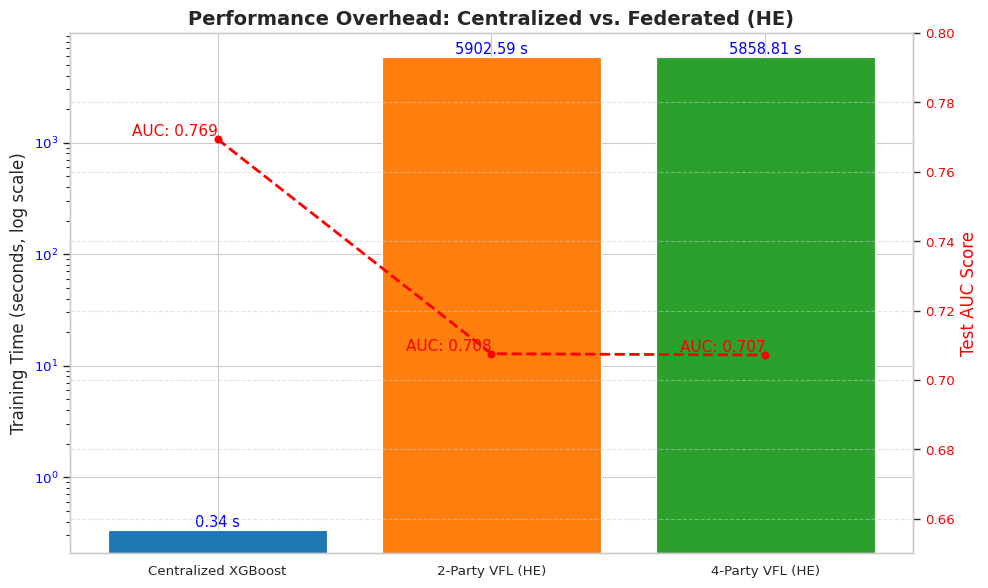

In [12]:
print("\n" + "="*30)
print("📊 Performance Overhead Analysis")
print("="*30)

# Store results
results = {
    'model': ['Centralized XGBoost', '2-Party VFL (HE)', '4-Party VFL (HE)'],
    'train_time_sec': [time_centralized, time_2p, time_4p],
    'test_auc': [auc_xgb, auc_2p, auc_4p]
}
df_results = pd.DataFrame(results)

print(df_results)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for training time on a log scale
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax.bar(df_results['model'], df_results['train_time_sec'], color=colors)
ax.set_yscale('log') # Use log scale for time
ax.set_ylabel('Training Time (seconds, log scale)', fontsize=12)
ax.set_title('Performance Overhead: Centralized vs. Federated (HE)', fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelcolor='blue')

# Add data labels for time
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f} s', va='bottom', ha='center', color='blue', fontweight='medium')

# Create a second y-axis for AUC
ax2 = ax.twinx()
ax2.plot(df_results['model'], df_results['test_auc'], color='red', marker='o', linestyle='--', linewidth=2, label='Test AUC')
ax2.set_ylabel('Test AUC Score', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0.65, 0.8) # Set AUC limits for clarity

# Add data labels for AUC
for i, txt in enumerate(df_results['test_auc']):
    ax2.text(i, txt, f'AUC: {txt:.3f}', va='bottom', ha='right', color='red', fontweight='medium', fontsize=11)

fig.tight_layout()
plt.grid(True, which="both", ls="--", alpha=0.5)

# Save the figure in a high-quality format suitable for LaTeX
plt.savefig('performance_overhead.pdf', format='pdf', dpi=300, bbox_inches='tight')
# Alternatively, for PNG:
plt.savefig('performance_overhead.png', format='png', dpi=300, bbox_inches='tight')
plt.show()